In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io as sio
import importlib
import pathlib
import os
import sys
import pickle 

sys.path.append(os.path.join('..'))

import sysid as sid
importlib.reload(sid)

<module 'sysid' from '/Users/felixfiedler/Documents/git_repos/2022_Robust_SPC/results/../sysid.py'>

In [6]:
sys.path.append('/Users/felixfiedler/Documents/ma27/compiled/lib/')

## Generate training data for the system identification

In [7]:
case = sid.SystemType.TRIPLE_MASS_SPRING

if case == sid.SystemType.TRIPLE_MASS_SPRING:
    # Setup data generation process
    sys_generator = sid.SystemGenerator(
        sys_type=sid.SystemType.TRIPLE_MASS_SPRING,
        sig_x=1e-1*np.array([2,1,0.5,0.1,0.1,0.1,0.1,0.1]),
        sig_y=1e-1,
        case_kwargs={'state_feedback':False},
        dt=0.1,
    )

    data_gen_setup = sid.DataGeneratorSetup(
        T_ini=3,
        N=20,
        n_samples=500,
    )
    # Class that generates a pseudo-random input signal
    random_input = sid.RandomInput(n_u=2)
    # Generate data
    data = sid.DataGenerator(sys_generator, data_gen_setup, random_input)

if case == sid.SystemType.BUILDING:
    sys_generator = sid.SystemGenerator(
        sys_type=sid.SystemType.BUILDING,
        sig_x=np.array([0,0,0,0,0.5]),
        sig_y=1e-1,
        dt=1,
    )

    random_input = sid.RandomInput(n_u=4, u_max=6)
    data_gen_setup = sid.DataGeneratorSetup(
        T_ini=1,
        N=12,
        n_samples=500,
    )
    # Generate data
    data = sid.DataGenerator(sys_generator, data_gen_setup, random_input)

## Fit multi-step model

In [11]:
# %%

msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
msm.fit(data)

Using custom sparsity for Sigma_e
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   142251

Total number of variables............................:     2281
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4650199e+02 0.00e+00 1.14e+01  -1.0 

## Fit state-space model

In [14]:

ssm = sid.StateSpaceModel(estimate_covariance=True, scale_y=False, scale_x=False)
ssm.fit(data)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1307

Total number of variables............................:       52
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0410678e+01 0.00e+00 5.88e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

/Users/felixfiedler/Documents/git_repos/2022_Robust_SPC/results/../bayli.py:50: UserWarning: Input data x is not scaled in BayesianLinearRegression. Please consider scaling the data yourself.
  warnings.warn('Input data x is not scaled in BayesianLinearRegression. Please consider scaling the data yourself.')
/Users/felixfiedler/Documents/git_repos/2022_Robust_SPC/results/../bayli.py:55: UserWarning: Output data y is not scaled in BayesianLinearRegression. Please consider scaling the data yourself.
  warnings.warn('Output data y is not scaled in BayesianLinearRegression. Please consider scaling the data yourself.')


## Generate (sampled) test data and evaluate the models
Samples are created with the same process noise as the training data but without measurmement noise.

In [19]:
if case == sid.SystemType.TRIPLE_MASS_SPRING:
    case_kwargs = {'state_feedback': False,
                   'x0': np.random.randn(8,1)}
elif case == sid.SystemType.BUILDING:
    case_kwargs = {
        'x0': np.array([20, 20.5, 19.5, 21, 10]).reshape(-1,1)
    }

test_data_setup = sid.DataGeneratorSetup(
    T_ini=data_gen_setup.T_ini,
    N=data_gen_setup.N,
    n_samples=300,
)

sys_generator_wo_meas_noise = sid.SystemGenerator(
    sys_type=sys_generator.sys_type,
    sig_x=sys_generator.sig_x,
    sig_y=0,
    case_kwargs=case_kwargs,
    dt=sys_generator.dt,
)

# Generate the same input sequence for all test cases 
random_input_sequence = random_input.gen_sequence(test_data_setup.L)
# Input object that returns the same input sequence
sequence_input = sid.InputFromSequence(random_input_sequence)
# Generate test data
test_samples = sid.DataGenerator(sys_generator_wo_meas_noise, test_data_setup, sequence_input)

### Evaluate both models

In [20]:

y_msm_pred, y_msm_pred_std = msm.predict(test_samples.M[:,[0]].T, uncert_type="std", with_noise_variance=True)
y_msm_pred = y_msm_pred.reshape(-1,test_samples.n_y)
y_msm_pred_std = y_msm_pred_std.reshape(-1,test_samples.n_y)

y_ssm_pred, y_ssm_pred_std = ssm.predict_sequence(test_samples.M[:,[0]], with_noise_variance=True)

(0.0, 1.0, 0.0, 1.0)

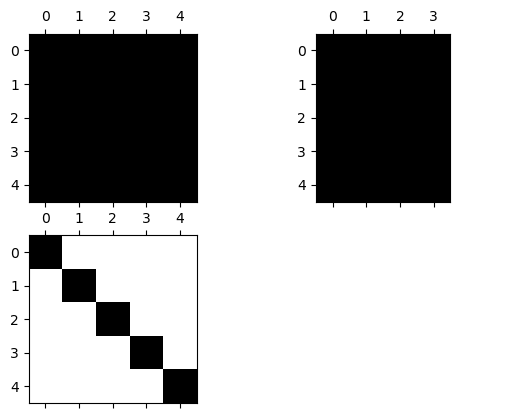

In [21]:
fig, ax = plt.subplots(2,2)
ax[0,0].spy(ssm.LTI.A)
ax[0,1].spy(ssm.LTI.B)
ax[1,0].spy(ssm.LTI.C)
ax[1,1].axis("off")

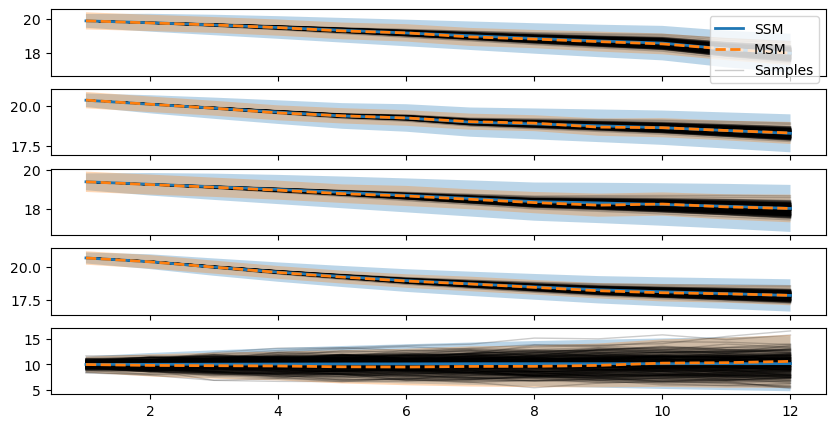

In [22]:

fig, ax = plt.subplots(test_samples.n_y,1, sharex=True, figsize=(10,5))

t_ini = test_samples.setup.T_ini

for i in range(test_samples.n_y):
    for sample in test_samples.sim_results:
        ax[i].plot(sample.time[t_ini:], sample.x[t_ini:,i], color='k',linewidth=1, alpha=0.2)
        pass

    ax[i].plot(sample.time[t_ini:], y_ssm_pred[:,i],linewidth=2, label="SSM")
    ax[i].fill_between(sample.time[t_ini:], y_ssm_pred[:,i]-3*y_ssm_pred_std[:,i], y_ssm_pred[:,i]+3*y_ssm_pred_std[:,i], alpha=0.3)

    ax[i].plot(sample.time[t_ini:], y_msm_pred[:,i], '--', linewidth=2, label="MSM")
    ax[i].fill_between(sample.time[t_ini:], y_msm_pred[:,i]-3*y_msm_pred_std[:,i], y_msm_pred[:,i]+3*y_msm_pred_std[:,i], alpha=0.3)

ax[0].plot([],[], color='k', linewidth=1, alpha=0.2, label="Samples")

ax[0].legend()

In [23]:
Y_pred = np.stack([sample.y[t_ini:] for sample in test_samples.sim_results],axis=2)

In [24]:
def get_normalized_distance(Y_true, y_pred, y_pred_std):
    norm_dist = np.abs(Y_true-np.atleast_3d(y_pred))/np.atleast_3d(y_pred_std)
    return norm_dist

def get_stats(Y_true, y_pred, y_pred_std):
    norm_dist = get_normalized_distance(Y_true, y_pred, y_pred_std)
    in_three_sigma = np.sum(norm_dist < 3)/np.prod(norm_dist.shape)
    three_sigma_percentile = np.percentile(norm_dist, 99.73, axis=[0,1,2])

    print("------------------------------")
    print(f"Portion of samples within 3 sigma: {in_three_sigma:.3f}")
    print(f"99.73 (3 Sigma) percentile of normalized distance (should be 3) : {three_sigma_percentile:.2f}")

    return in_three_sigma, three_sigma_percentile

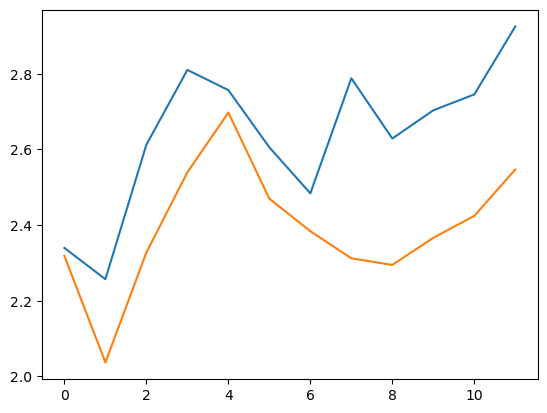

In [25]:
norm_dist_msm = get_normalized_distance(Y_pred, y_msm_pred, y_msm_pred_std)
norm_dist_ssm = get_normalized_distance(Y_pred, y_ssm_pred, y_ssm_pred_std)
traj_perc_norm_dist_msm = np.percentile(norm_dist_msm, 99.73, axis=[1,2])
traj_perc_norm_dist_ssm = np.percentile(norm_dist_ssm, 99.73, axis=[1,2])

fig, ax = plt.subplots()
ax.plot(traj_perc_norm_dist_msm, label="MSM")
ax.plot(traj_perc_norm_dist_ssm, label="SSM")

In [26]:
print('MSM')
msm_stats = get_stats(Y_pred, y_msm_pred, y_msm_pred_std)
print('SSM')
ssm_stats = get_stats(Y_pred, y_ssm_pred, y_ssm_pred_std)

MSM
------------------------------
Portion of samples within 3 sigma: 0.999
99.73 (3 Sigma) percentile of normalized distance (should be 3) : 2.72
SSM
------------------------------
Portion of samples within 3 sigma: 0.999
99.73 (3 Sigma) percentile of normalized distance (should be 3) : 2.49


In [27]:
C = data.sim_results[0].C
logprob = -.5*((y_msm_pred-sample.x[t_ini:]@C.T)/y_msm_pred_std)**2-.5*np.log(2*np.pi)-np.log(y_msm_pred_std)

Save the identified models to file

In [30]:
result_dir = os.path.join('sid_results')
name_suffix = "prediction_models"


if case == sid.SystemType.TRIPLE_MASS_SPRING:
    save_name = "mass_spring_{}.pkl".format(name_suffix)
if case == sid.SystemType.BUILDING:
    save_name = "building_{}.pkl".format(name_suffix)

save_name = os.path.join(result_dir, save_name)

pathlib.Path(result_dir).mkdir(parents=True, exist_ok=True)

with open(save_name, "wb") as f:
    res = {'msm': msm, 'ssm': ssm}
    pickle.dump(res, f)

In [31]:
with open(save_name, "rb") as f:
    res = pickle.load(f)
    # ssm = res['ssm']
    # msm = res['msm']
